<a href="https://colab.research.google.com/github/ariel07-sw/applied-data-in-econ/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fredapi

In [ ]:
import pandas as pd
from fredapi import Fred

In [ ]:
fred=Fred(api_key='8f3b5b913ce6458b820a44a47b134d05')

In [ ]:
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})
df = df.dropna()
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [ ]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


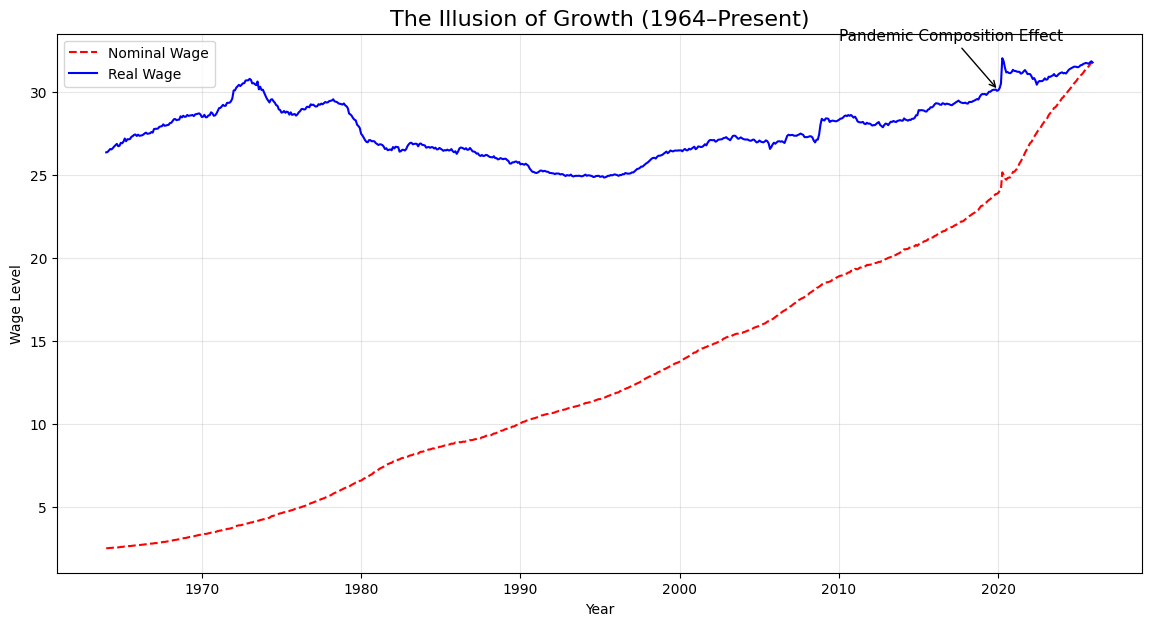

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Nominal Wage: dashed red
plt.plot(
    df.index,
    df['Nominal_Wage'],
    linestyle='--',
    color='red',
    label='Nominal Wage'
)

# Real Wage: solid blue
plt.plot(
    df.index,
    df['Real_Wage'],
    color='blue',
    label='Real Wage'
)

# Titles and labels
plt.title('The Illusion of Growth (1964–Present)', fontsize=16)
plt.xlabel('Year')
plt.ylabel('Wage Level')
plt.legend()

# ---- Annotate the 2020 spike (SAFE VERSION) ----
year_2020 = pd.Timestamp('2020-01-01')
y_2020 = df.loc[year_2020, 'Real_Wage']

plt.annotate(
    'Pandemic Composition Effect',
    xy=(year_2020, y_2020),
    xytext=(pd.Timestamp('2010-01-01'), y_2020 * 1.1),
    arrowprops=dict(arrowstyle='->'),
    fontsize=11
)

plt.grid(True, alpha=0.3)
plt.show()


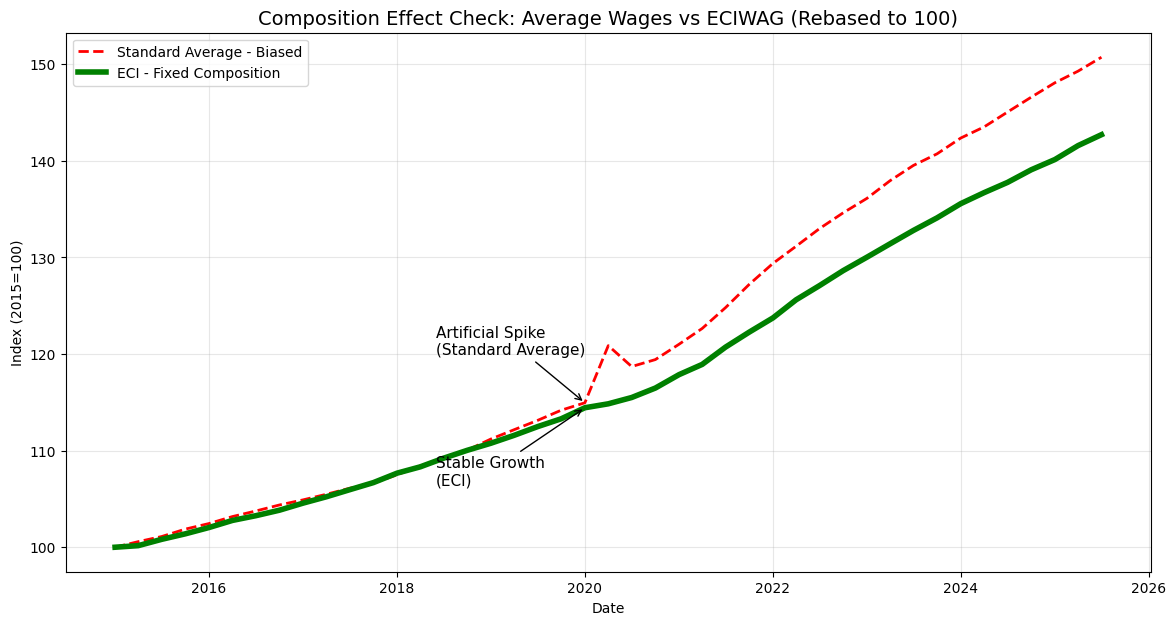

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------
# 1) Fetch ECIWAG from FRED
# ---------------------------
eci = fred.get_series('ECIWAG')  # pandas Series
eci.name = 'ECIWAG'

# ---------------------------
# 2) Filter both to 2015-01-01+
# ---------------------------
start = pd.Timestamp('2015-01-01')

w = wages.copy()
# Ensure datetime index
w.index = pd.to_datetime(w.index)
eci.index = pd.to_datetime(eci.index)

w = w.loc[w.index >= start].sort_index()
eci = eci.loc[eci.index >= start].sort_index()

# Align on common dates (keeps only overlapping timestamps)
w, eci = w.align(eci, join='inner')

# ---------------------------
# 3) Rebase both to 100
# ---------------------------
w_rebased = (w / w.iloc[0]) * 100
eci_rebased = (eci / eci.iloc[0]) * 100

# ---------------------------
# 4) Plot both series
# ---------------------------
plt.figure(figsize=(14, 7))

plt.plot(
    w_rebased.index, w_rebased.values,
    linestyle='--', color='red', linewidth=2,
    label='Standard Average - Biased'
)

plt.plot(
    eci_rebased.index, eci_rebased.values,
    linestyle='-', color='green', linewidth=4,
    label='ECI - Fixed Composition'
)

plt.title('Composition Effect Check: Average Wages vs ECIWAG (Rebased to 100)', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Index (2015=100)')
plt.legend()
plt.grid(True, alpha=0.3)

# ---------------------------
# 5) Annotate the 2020 divergence
# ---------------------------
# Use 2020-01-01 if present; otherwise pick the closest date in 2020
target = pd.Timestamp('2020-01-01')
if target in w_rebased.index:
    t = target
else:
    # Find closest available date in 2020 for wages
    in_2020 = w_rebased.loc['2020-01-01':'2020-12-31']
    t = in_2020.index[0] if len(in_2020) > 0 else w_rebased.index[w_rebased.index.get_indexer([target], method='nearest')[0]]

w_2020 = w_rebased.loc[t]
eci_2020 = eci_rebased.loc[t]

# Arrow to wage spike
plt.annotate(
    'Artificial Spike\n(Standard Average)',
    xy=(t, w_2020),
    xytext=(pd.Timestamp('2018-06-01'), w_2020 + 5),
    arrowprops=dict(arrowstyle='->'),
    fontsize=11
)

# Arrow to ECI stable path
plt.annotate(
    'Stable Growth\n(ECI)',
    xy=(t, eci_2020),
    xytext=(pd.Timestamp('2018-06-01'), eci_2020 - 8),
    arrowprops=dict(arrowstyle='->'),
    fontsize=11
)

plt.show()
